#### Version 08
First submission: I used my own text preprocessing, passing it through a CounterVectorizer() with ngram set up to be (1,2) (allowing both unigrams and bigrams). For the ML model, I chose Ridge Rgression with an alpha of 16000.My random seed is 73.

In [1]:
# all imports and magic commands
import re
# import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from part_of_speech import get_part_of_speech

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [8]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [2]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    reviews = movie_data.review
    lemmatizer = WordNetLemmatizer()
    porter_stemmer=PorterStemmer()
    CLEANR = re.compile('<.*?>') 
 #https://kavita-ganesan.com/how-to-use-countvectorizer/#.YjpnbprMIqw   
    def my_preprocessor(text):
        text=text.lower() 
        text=re.sub("\\W"," ",text) # remove special chars
        text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    
    # stem words
    # words=re.split("\\s+",text)
    # stemmed_words=[porter_stemmer.stem(word=word) for word in words]

    # part_of_speech
    # lemmatization
        tokenized_string = word_tokenize(text)
        stemmed_words = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized_string]
        return ' '.join(stemmed_words)

    print(movie_data.head(10))
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(ngram_range=(1,2), preprocessor=my_preprocessor)
        X_hv = hv.fit_transform(reviews)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(reviews)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = reviews.str.split(' ').str.len()
    movie_data['punc_count'] = reviews.str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [3]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10          1  <br /><br />This movie is full of references. ...
movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review  

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [4]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("performance_measures is:", type(ols_performance_train.performance_measures))

{'Pos': 10000, 'Neg': 10000, 'TP': 3473, 'TN': 6714, 'FP': 3286, 'FN': 6527, 'Accuracy': 0.50935, 'Precision': 0.5138334073087735, 'Recall': 0.3473, 'desc': 'ols_train'}
performance_measures is: <class 'dict'>


### MODEL: SVM, linear

In [5]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [6]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [8]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [9]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=16000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 8163, 'TN': 6965, 'FP': 3035, 'FN': 1837, 'Accuracy': 0.7564, 'Precision': 0.7289694588319343, 'Recall': 0.8163, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

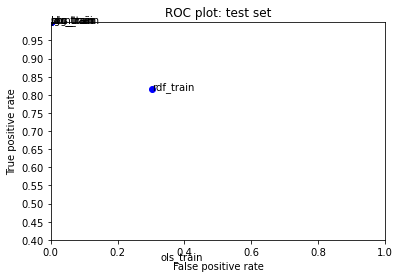

In [11]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
logistic reg                   1.0000               0.0000
naive bayes                    1.0000               0.0000
perceptron                     1.0000               0.0000
ridge reg                      1.0000               0.0000
support vector                 1.0000               0.0000
random forest                  0.8163               0.3035
ordinary least sq              0.3473               0.3286


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [16]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [19]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 859, 'TN': 1695, 'FP': 805, 'FN': 1641, 'Accuracy': 0.5108, 'Precision': 0.5162259615384616, 'Recall': 0.3436, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [20]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2088, 'TN': 2122, 'FP': 378, 'FN': 412, 'Accuracy': 0.842, 'Precision': 0.8467153284671532, 'Recall': 0.8352, 'desc': 'svm_test'}


### MODEL: logistic regression

In [21]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2118, 'TN': 2119, 'FP': 381, 'FN': 382, 'Accuracy': 0.8474, 'Precision': 0.8475390156062425, 'Recall': 0.8472, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [22]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1990, 'TN': 2098, 'FP': 402, 'FN': 510, 'Accuracy': 0.8176, 'Precision': 0.8319397993311036, 'Recall': 0.796, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [23]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2114, 'TN': 2094, 'FP': 406, 'FN': 386, 'Accuracy': 0.8416, 'Precision': 0.8388888888888889, 'Recall': 0.8456, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [24]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2311, 'TN': 2173, 'FP': 327, 'FN': 189, 'Accuracy': 0.8968, 'Precision': 0.8760424564063685, 'Recall': 0.9244, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [25]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)
print(rdf_performance_test)

{'Pos': 2500, 'Neg': 2500, 'TP': 2006, 'TN': 1736, 'FP': 764, 'FN': 494, 'Accuracy': 0.7484, 'Precision': 0.7241877256317689, 'Recall': 0.8024, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

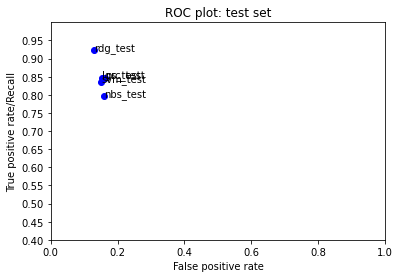

In [26]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [27]:
#https://pavopax.github.io/2017/11/precision-recall/
#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba#:~:text=Recall%20and%20True%20Positive%20Rate,denominator%20contains%20the%20true%20negatives.
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
ridge reg                      0.9244               0.1308
logistic reg                   0.8472               0.1524
perceptron                     0.8456               0.1624
support vector                 0.8352               0.1512
random forest                  0.8024               0.3056
naive bayes                    0.7960               0.1608
ordinary least sq              0.3436               0.3220


---

# <span style="color:red">SUBMISSION</span>

---

In [28]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/moviereviews_test.tsv', my_random_seed=73, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
5    2913_8  ...as valuable as King Tut's tomb! (OK, maybe ...
6    4396_1  This has to be one of the biggest misfires eve...
7     395_2  This is one of those movies I watched, and won...
8   10616_1  The worst movie i've seen in years (and i've s...
9    9074_9  Five medical students (Kevin Bacon, David Labr...
movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10 

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [29]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49912


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [30]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1


In [31]:
my_submission.shape

(25000, 2)

In [33]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../data/moviereviews_submissions01.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation